In [69]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score
import metrics as mt
import matplotlib.pyplot as plt
import seaborn as sns

In [70]:
results = {
    'liga' : [],
    'modelo' : [],
    'season' : [],
    'acc' : [],
    'rps' : [],
    'number_matches' : [],
    'preds' : [],
    'class' : [],
    'real' : [],
}

In [71]:
ligas = {
    #'England' : [39],
    'Spain' : [140],
    #'France': [61],
    #'Brazil' : [71],
    #'Germany' : [78],
    #'Italy' : [135],
    #'Netherlands' : [88],
    #'Argentina' : [128],
    }

In [93]:
for liga, id_liga in ligas.items():
    caminho = r'data\processed\batch_article\\'

    base = f'batch_{id_liga[0]}_xgboos_TESTE.xlsx' 

    df = pd.read_excel(caminho + base)

    df = df.dropna()

    df['Result'] = np.where(df['Home Score'] > df['Away Score'], 1, np.where(df['Home Score'] < df['Away Score'], 2, 0))

    df = df[~filtro]

    df = df.sort_values(by='Kick Off')

    df =  df.drop(['Home Team', 'Away Team', 'Country', 'League', 'Kick Off', 'Home Score',
            'Away Score', 'league_round', 'ts', 'fixture_id', 'teams_home_id', 
            'teams_away_id', 'player_home_0', 'player_home_1', 'player_home_2', 'player_home_3', 'player_home_4',
            'player_home_5', 'player_home_6', 'player_home_7', 'player_home_8', 'player_home_9', 'player_home_10',
            'player_away_0', 'player_away_1', 'player_away_2', 'player_away_3', 'player_away_4', 'player_away_5', 
            'player_away_6', 'player_away_7', 'player_away_8', 'player_away_9', 'player_away_10'], axis=1)
    
    # Defina os parâmetros do modelo XGBoost
    params = {
        'max_depth': 4,
        'subsample': 0.8,
        'min_child_weight': 5,
        'colsample_bytree': 0.25,
        'num_class': 3,
        'objective': 'multi:softmax',
        'eval_metric': 'mlogloss',
    }


    seasons = df['league_season'].unique()

    for i in range(1, len(seasons)):
        trein = seasons[:i]
        test = [seasons[i]]

        #### Defininfo conjuntos de treino e teste
        X_train = df[df['league_season'].isin(trein)].drop(columns=['Result', 'league_season'])
        X_test = df[df['league_season'].isin(test)].drop(columns=['Result', 'league_season'])
        
        X_train = X_train.apply(pd.to_numeric)
        X_test = X_test.apply(pd.to_numeric)

        X_train_xgboos = X_train.drop(columns= X_train.filter(like='embeddings_').columns.to_list())
        X_test_xgboos = X_test.drop(columns= X_test.filter(like='embeddings_').columns.to_list())

        X_train_embeddings = X_train[X_train.filter(like='embeddings_').columns.to_list()]
        X_test_embeddings = X_test[X_test.filter(like='embeddings_').columns.to_list()]
        
        y_train = df[df['league_season'].isin(trein)]['Result']
        y_test = df[df['league_season'].isin(test)]['Result']

        # Crie objetos DMatrix para treinamento e teste
        dtrain = xgb.DMatrix(X_train, label=y_train)
        dtest = xgb.DMatrix(X_test, label=y_test)

        dtrain_xgbost = xgb.DMatrix(X_train_xgboos, label=y_train)
        dtest_xgboost = xgb.DMatrix(X_test_xgboos, label=y_test)

        dtrain_embeddings = xgb.DMatrix(X_train_embeddings, label=y_train)
        dtest_embeddings = xgb.DMatrix(X_test_embeddings, label=y_test)

        # Treinando os modelos XGBoost
        num_round = 1000
        bst = xgb.train(params, dtrain, num_round, evals=[(dtest, 'test')], early_stopping_rounds=10)

        num_round = 1000
        bst_xgboost = xgb.train(params, dtrain_xgbost, num_round, evals=[(dtest_xgboost, 'test')], early_stopping_rounds=10)

        num_round = 1000
        bst_embeddings = xgb.train(params, dtrain_embeddings, num_round, evals=[(dtest_embeddings, 'test')], early_stopping_rounds=10)

        # Avaliando os modelos
        #####################################################################
        y_pred = bst.predict(dtest)
        results['class'].append(y_pred)
        results['modelo'].append('bst')
        results['liga'].append(liga)
        results['season'].append(test[0])
        results['acc'].append(accuracy_score(y_test, y_pred))
        results['real'].append(y_test.to_numpy())
        results['number_matches'].append(len(X_train))
        

        y_pred = bst.predict(dtest, output_margin=True)

        # Aplica a função softmax para obter probabilidades normalizadas
        y_pred = np.exp(y_pred - np.max(y_pred, axis=1, keepdims=True))
        y_pred /= np.sum(y_pred, axis=1, keepdims=True)

        rps = mt.rps(y_pred, mt.get_class_indicator(y_test))
        results['preds'].append(y_pred)
        results['rps'].append(rps)
        
        ###########################################################################
        y_pred = bst_xgboost.predict(dtest_xgboost)
        results['class'].append(y_pred)
        results['modelo'].append('bst_xgboost')
        results['liga'].append(liga)
        results['season'].append(test[0])
        results['acc'].append(accuracy_score(y_test, y_pred))
        results['real'].append(y_test.to_numpy())
        results['number_matches'].append(len(X_train))

        y_pred = bst_xgboost.predict(dtest_xgboost, output_margin=True)

        # Aplica a função softmax para obter probabilidades normalizadas
        y_pred = np.exp(y_pred - np.max(y_pred, axis=1, keepdims=True))
        y_pred /= np.sum(y_pred, axis=1, keepdims=True)

        rps = mt.rps(y_pred, mt.get_class_indicator(y_test))
        results['preds'].append(y_pred)
        results['rps'].append(rps)
        ##################################################################

        y_pred = bst_embeddings.predict(dtest_embeddings)
        results['class'].append(y_pred)
        results['modelo'].append('bst_embeddings')
        results['liga'].append(liga)
        results['season'].append(test[0])
        results['acc'].append(accuracy_score(y_test, y_pred))
        results['real'].append(y_test.to_numpy())
        results['number_matches'].append(len(X_train))

        y_pred = bst_embeddings.predict(dtest_embeddings, output_margin=True)

        # Aplica a função softmax para obter probabilidades normalizadas
        y_pred = np.exp(y_pred - np.max(y_pred, axis=1, keepdims=True))
        y_pred /= np.sum(y_pred, axis=1, keepdims=True)

        rps = mt.rps(y_pred, mt.get_class_indicator(y_test))
        results['preds'].append(y_pred)
        results['rps'].append(rps)
        ##################################################################
    

[0]	test-mlogloss:1.07829
[1]	test-mlogloss:1.08223
[2]	test-mlogloss:1.08557
[3]	test-mlogloss:1.08359
[4]	test-mlogloss:1.08379
[5]	test-mlogloss:1.09405
[6]	test-mlogloss:1.09677
[7]	test-mlogloss:1.09798
[8]	test-mlogloss:1.09376
[9]	test-mlogloss:1.10193
[10]	test-mlogloss:1.10158
[0]	test-mlogloss:1.07082
[1]	test-mlogloss:1.05999
[2]	test-mlogloss:1.04410
[3]	test-mlogloss:1.05223
[4]	test-mlogloss:1.05075
[5]	test-mlogloss:1.05663
[6]	test-mlogloss:1.06525
[7]	test-mlogloss:1.07443
[8]	test-mlogloss:1.08079
[9]	test-mlogloss:1.08970
[10]	test-mlogloss:1.08654
[11]	test-mlogloss:1.09571
[0]	test-mlogloss:1.07725
[1]	test-mlogloss:1.07207
[2]	test-mlogloss:1.06056
[3]	test-mlogloss:1.05883
[4]	test-mlogloss:1.05828
[5]	test-mlogloss:1.06322
[6]	test-mlogloss:1.07270
[7]	test-mlogloss:1.07616
[8]	test-mlogloss:1.07859
[9]	test-mlogloss:1.07947
[10]	test-mlogloss:1.07899
[11]	test-mlogloss:1.08280
[12]	test-mlogloss:1.08608
[13]	test-mlogloss:1.09376
[14]	test-mlogloss:1.09983
[0]	

In [94]:
caminho = r'data\processed\batch_article\\'

base = f'batch_{id_liga[0]}_xgboos_TESTE.xlsx' 

df = pd.read_excel(caminho + base)

df = df.dropna()

df['Result'] = np.where(df['Home Score'] > df['Away Score'], 1, np.where(df['Home Score'] < df['Away Score'], 2, 0))

filtro = (df['Home Team'] == 'Jogo1_Sem_Messi') | \
        (df['Home Team'] == 'Jogo1_Sem_Messi_e_sem_saurez') | \
        ((df['Home Team'] == 'Real Madrid') & \
         (df['Away Team'] == 'Barcelona') & \
        (df['league_season'] == 2018)) 

df = df[filtro]

display(df)

df =  df.drop(['Home Team', 'league_season','Away Team', 'Country', 'League', 'Kick Off', 'Home Score',
        'Away Score', 'league_round', 'ts', 'fixture_id', 'teams_home_id', 
        'teams_away_id', 'player_home_0', 'player_home_1', 'player_home_2', 'player_home_3', 'player_home_4',
        'player_home_5', 'player_home_6', 'player_home_7', 'player_home_8', 'player_home_9', 'player_home_10',
        'player_away_0', 'player_away_1', 'player_away_2', 'player_away_3', 'player_away_4', 'player_away_5', 
        'player_away_6', 'player_away_7', 'player_away_8', 'player_away_9', 'player_away_10'], axis=1)

x = df.drop(columns=['Result']).apply(pd.to_numeric)
y = df['Result']

previsoes_output_margin = bst.predict(xgb.DMatrix(x, label=y), output_margin=True)
np.exp(previsoes_output_margin) / np.sum(np.exp(previsoes_output_margin), axis=1)[:, np.newaxis]

,Home Team,Away Team,Country,League,Kick Off,Home Score,Away Score,league_season,league_round,fixture_id,...,H_DIFFERENCE_5LT,A_DIFFERENCE_1LT,A_DIFFERENCE_2LT,A_DIFFERENCE_3LT,A_DIFFERENCE_4LT,A_DIFFERENCE_5LT,RND,pagerank_home,pagerank_away,Result
1393,Jogo1_Sem_Messi,Jogo1_Sem_Messi_2,Spain,La Liga,2019-03-02 19:45:00 UTC,0,1,2018,26,27395,...,-0.88,-1.52,-1.36,-1.36,-1.28,-1.24,26,4.915006e+07,5.037137e+07,2
1394,Jogo1_Sem_Messi_e_sem_saurez,Jogo1_Sem_Messi_e_sem_saurez_2,Spain,La Liga,2019-03-02 19:45:00 UTC,0,1,2018,26,27395,...,-0.88,-1.52,-1.36,-1.36,-1.28,-1.24,26,4.915006e+07,5.037137e+07,2
1395,Real Madrid,Barcelona,Spain,La Liga,2019-03-02 19:45:00 UTC,0,1,2018,26,27395,...,-0.88,-1.52,-1.36,-1.36,-1.28,-1.24,26,4.915006e+07,5.037137e+07,2


array([[0.23253205, 0.41060448, 0.35686353],
       [0.32822427, 0.3889709 , 0.28280482],
       [0.19826327, 0.4217309 , 0.3800058 ]], dtype=float32)

,embeddings_home_0,embeddings_home_1,embeddings_home_2,embeddings_home_3,embeddings_home_4,embeddings_home_5,embeddings_home_6,embeddings_home_7,embeddings_home_8,embeddings_home_9,...,H_DIFFERENCE_5LT,A_DIFFERENCE_1LT,A_DIFFERENCE_2LT,A_DIFFERENCE_3LT,A_DIFFERENCE_4LT,A_DIFFERENCE_5LT,RND,pagerank_home,pagerank_away,Result
1393,0.0,0.0,25.50272,0.0,13.595369,9.343292,0.0,0.0,17.402533,3.407246,...,-0.88,-1.52,-1.36,-1.36,-1.28,-1.24,26,4.915006e+07,5.037137e+07,2
2918,0.0,0.0,25.50272,0.0,13.595369,9.343292,0.0,0.0,17.402533,3.407246,...,-0.88,-1.52,-1.36,-1.36,-1.28,-1.24,26,4.915006e+07,5.037137e+07,2
2919,0.0,0.0,25.50272,0.0,13.595369,9.343292,0.0,0.0,17.402533,3.407246,...,-0.88,-1.52,-1.36,-1.36,-1.28,-1.24,26,4.915006e+07,5.037137e+07,2


In [8]:
for ii in results.keys():
    print(ii, len(results[ii]))


liga 15
modelo 15
season 15
acc 15
rps 15
number_matches 15
preds 15
class 15
real 15


In [6]:
jogos_por_ano = pd.DataFrame(results).groupby(['liga','season']).agg({
    'number_matches' : 'mean'
    }).reset_index()#.to_excel('apagar.xlsx', index=False)

jogos_por_ano = jogos_por_ano.groupby(['season']).agg({'number_matches' : 'sum'}).reset_index()

In [7]:
def concat_arrays(series):
    return np.mean(np.concatenate(series.values))

# Agrupamento e aplicação da função de concatenação
resultados = pd.DataFrame(results).groupby(['modelo', 'season']).agg({
        'acc': 'mean',
        'rps': lambda x: concat_arrays(x)
        }).reset_index()#.to_excel('apagar.xlsx', index=False)


In [8]:
pd.merge(resultados, jogos_por_ano, on=['season'], how='left')#.to_excel('apagar.xlsx', index=False)

,modelo,season,acc,rps,number_matches
0,bst,2017,0.504000,0.194238,374.0
1,bst,2018,0.497743,0.193918,2848.0
2,bst,2019,0.476152,0.196407,5639.0
3,bst,2020,0.489901,0.202944,8179.0
4,bst,2021,0.470098,0.198931,10787.0
5,bst,2022,0.489011,0.199231,13748.0
6,bst,2023,0.370370,0.212555,1759.0
7,bst_embeddings,2017,0.525333,0.200177,374.0
8,bst_embeddings,2018,0.480569,0.194508,2848.0
9,bst_embeddings,2019,0.448380,0.201221,5639.0


In [9]:
pd.DataFrame(results).groupby(['modelo']).agg({
        'acc': 'mean',
        'rps': lambda x: concat_arrays(x)
        }).reset_index()#.to_excel('apagar.xlsx', index=False)


,modelo,acc,rps
0,bst,0.481948,0.198347
1,bst_embeddings,0.464662,0.200816
2,bst_xgboost,0.477221,0.198568


In [10]:
preds = pd.DataFrame(results)
preds = preds[preds['season'] == 2022].reset_index()
preds = preds.groupby('modelo').agg({
                                    'preds': lambda x: np.concatenate(x.to_numpy()),
                                    'class': lambda x: np.concatenate(x.to_numpy()),
                                    'real' : lambda x: np.concatenate(x.to_numpy()),
                                }).reset_index()
preds

,modelo,preds,class,real
0,bst,"[[0.266683, 0.3468038, 0.3865132], [0.2837144,...","[2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, ...","[2, 1, 1, 2, 0, 2, 2, 1, 0, 1, 0, 1, 0, 0, 1, ..."
1,bst_embeddings,"[[0.29996592, 0.4951415, 0.20489259], [0.21746...","[1.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, ...","[2, 1, 1, 2, 0, 2, 2, 1, 0, 1, 0, 1, 0, 0, 1, ..."
2,bst_xgboost,"[[0.30956104, 0.2953512, 0.3950877], [0.277613...","[2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, ...","[2, 1, 1, 2, 0, 2, 2, 1, 0, 1, 0, 1, 0, 0, 1, ..."


In [11]:
bst_pred = preds[preds['modelo'] == 'bst']['preds'].iloc[0]
bst_pred = np.column_stack((bst_pred[:, 0], 
                            np.sum(bst_pred[:, 1:3], axis=1)))

bst_embeddings_pred = preds[preds['modelo'] == 'bst_embeddings']['preds'].iloc[0]
bst_embeddings_pred = np.column_stack((bst_embeddings_pred[:, 0], 
                            np.sum(bst_embeddings_pred[:, 1:3], axis=1)))


bst_xgboost_pred = preds[preds['modelo'] == 'bst_xgboost']['preds'].iloc[0]
bst_embeddings_pred = np.column_stack((bst_xgboost_pred[:, 0], 
                            np.sum(bst_xgboost_pred[:, 1:3], axis=1)))

real = np.where(preds['real'].values[0] != 0, 1, preds['real'].values[0])


In [12]:
def cdf(sample, x, sort = False):
    '''
    Return the value of the Cumulative Distribution Function, evaluated for a given sample and a value x.
    
    Args:
        sample: The list or array of observations.
        x: The value for which the numerical cdf is evaluated.
    
    Returns:
        cdf = CDF_{sample}(x)
    '''
    
    # Sorts the sample, if needed
    if sort:
        sample.sort()
    
    # Counts how many observations are below x
    cdf = sum(sample <= x)
    
    # Divides by the total number of observations
    cdf = cdf / len(sample)
    
    return cdf

In [13]:
# Gets the class CDFs
def get_classes_cdf(y_real, y_proba):
    # Unite both visions to be able to filter
    df = pd.DataFrame()
    df['real'] = y_real
    df['proba'] = y_proba[:, 1]
    
    # Recover each class
    class0 = df[df['real'] == 0].sort_values('proba')
    class1 = df[df['real'] != 0].sort_values('proba')
    
    # Calculates the cdfs
    cdf0 = np.array([cdf(class0['proba'].values, x, sort = False) for x in class0['proba'].values])
    cdf1 = np.array([cdf(class1['proba'].values, x, sort = False) for x in class1['proba'].values])
    
    # Results
    results =  {
        'cdf0': cdf0,
        'cdf1': cdf1,
        'proba0': class0['proba'].values, 
        'proba1': class1['proba'].values, 
    }
    
    return results

In [14]:
from scipy.stats import ks_2samp
from sklearn.metrics import roc_auc_score

def evaluate_ks_and_roc_auc(y_real, y_proba):
    # Unite both visions to be able to filter
    df = pd.DataFrame()
    df['real'] = y_real
    df['proba'] = y_proba[:, 1]
    
    # Recover each class
    class0 = df[df['real'] == 0]
    class1 = df[df['real'] != 0]
    
    ks = ks_2samp(class0['proba'], class1['proba'])
    roc_auc = roc_auc_score(df['real'] , df['proba'])
    
    print(f"KS: {ks.statistic:.4f} (p-value: {ks.pvalue:.3e})")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    return ks.statistic, roc_auc

In [19]:
print("bst_pred")
evaluate_ks_and_roc_auc(real, bst_pred)
print("###")
print("bst_embeddings_pred")
evaluate_ks_and_roc_auc(real, bst_embeddings_pred)
print("###")
print("bst_xgboost_pred")
evaluate_ks_and_roc_auc(real, bst_xgboost_pred)
print("###")


bst_pred
KS: 0.0320 (p-value: 6.926e-01)
ROC AUC: 0.5091
###
bst_embeddings_pred
KS: 0.0649 (p-value: 3.323e-02)
ROC AUC: 0.5281
###
bst_xgboost_pred
KS: 0.0622 (p-value: 4.607e-02)
ROC AUC: 0.5158
###


In [15]:
cdf_bst = get_classes_cdf(real, bst_pred)
cdf_bst_embeddings = get_classes_cdf(real, bst_embeddings_pred)
cdf_bst_xgboost = get_classes_cdf(real, bst_xgboost_pred)

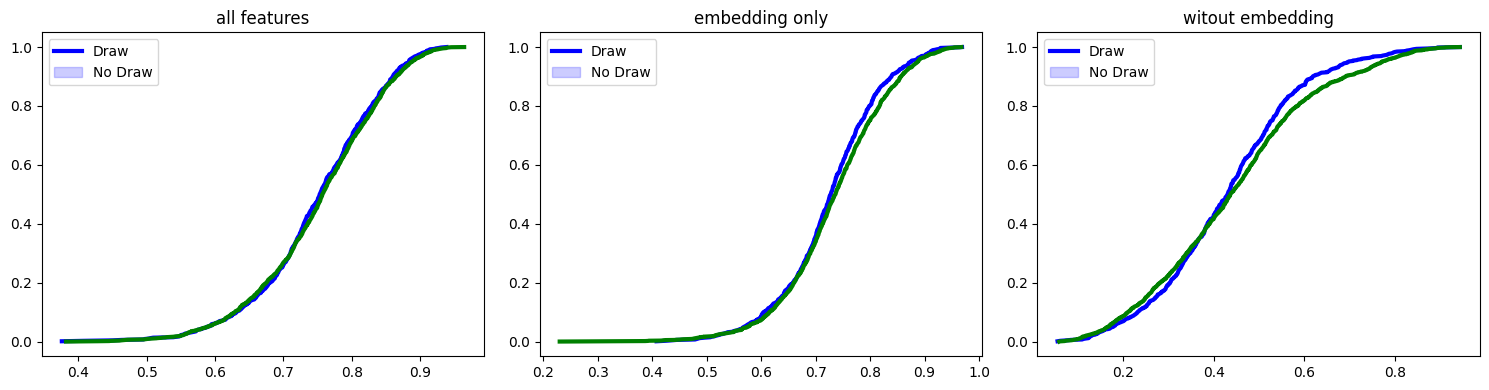

In [16]:
# Visualize them
fig = plt.figure(figsize = (15, 4))
ax1 = plt.subplot(1, 3, 1)
ax2 = plt.subplot(1, 3, 2)
ax3 = plt.subplot(1, 3, 3)

ax1.set_title("all features")
sns.lineplot(x = cdf_bst['proba0'], y = cdf_bst['cdf0'], color = 'b', ax = ax1, linewidth = 3)
sns.lineplot(x = cdf_bst['proba1'], y = cdf_bst['cdf1'], color = 'g', ax = ax1, linewidth = 3)
ax1.legend(["Draw", "No Draw"])

ax2.set_title("embedding only")
sns.lineplot(x = cdf_bst_embeddings['proba0'], y = cdf_bst_embeddings['cdf0'], color = 'b', ax = ax2, linewidth = 3)
sns.lineplot(x = cdf_bst_embeddings['proba1'], y = cdf_bst_embeddings['cdf1'], color = 'g', ax = ax2, linewidth = 3)
ax2.legend(["Draw", "No Draw"])

ax3.set_title("witout embedding")
sns.lineplot(x = cdf_bst_xgboost['proba0'], y = cdf_bst_xgboost['cdf0'], color = 'b', ax = ax3, linewidth = 3)
sns.lineplot(x = cdf_bst_xgboost['proba1'], y = cdf_bst_xgboost['cdf1'], color = 'g', ax = ax3, linewidth = 3)
ax3.legend(["Draw", "No Draw"])

plt.tight_layout()